In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 250)

# babi-long


In [24]:
!cd ..; python parse_tb.py

  0%|          | 0/785 [00:00<?, ?it/s]
2023-08-07 14:56:38.636642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-07 14:56:38.636694: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [58]:
res_df = pd.read_csv('../results/babilong_compare_curriculum.csv')

In [59]:
res_df = res_df[res_df.model_path.apply(lambda x: 'from_cpt' in x or 'regular/' in x)]
res_df = res_df[(res_df.max_n_segments == 4) & (res_df.num_mem_tokens == 10) & (res_df.from_pretrained == 'bert-base-cased')]

In [60]:
# res_df['memory_layers'] = res_df.memory_layers.fillna('')
# res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


In [69]:
eval_df = res_df[res_df.num_steps > 1000].copy()
gb = eval_df[['best_valid_exact_match', 'tag']].groupby(['tag']).mean()

In [79]:
gb.index == ['naive training', 'curriculum learning']
gb.columns = ['4-segment memorization accuracy']

In [90]:
gb.values[:, 0]

array([ 20.88122559, 100.        ])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


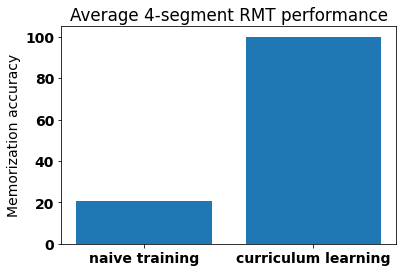

In [110]:
plt.figure(figsize=(6, 4))

font = {'size' : 14}

plt.rc('font', **font)

plt.bar(gb.index, height=gb.values[:, 0])
plt.title('Average 4-segment RMT performance')
plt.ylabel('Memorization accuracy')
plt.savefig('img/babi_curr_vs_no_curr.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [253]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']

In [254]:
# group_df

In [256]:
group_df

best_valid_exact_match  \
from_pretrained max_n_segments num_mem_tokens memory_layers horizontal_memory input_size tag                                     
bert-base-cased 1              10                           False             512        _from_cpt_0-1               72.299999   
                2              10                           False             512        _from_cpt_1-2               97.190001   
                3              10                           False             512        _from_cpt_2-3               89.966665   
                4              10                           False             512        _from_cpt_3-4               96.800003   
                5              10                           False             512        _from_cpt_4-5               94.800003   

                                                                                                              std  \
from_pretrained max_n_segments num_mem_tokens memory_layers horizontal_memory input_size tag                        
bert-base-cased 1              10                           False             512        _from_cpt_0-1  42.603192   
                2              10                           False             512        _from_cpt_1-2   2.540276   
                3              10                           False             512        _from_cpt_2-3   6.853890   
                4              10                           False             512        _from_cpt_3-4        NaN   
                5              10                           False             512        _from_cpt_4-5        NaN   

                                                                                                        n_runs  \
from_pretrained max_n_segments num_mem_tokens memory_layers horizontal_memory input_size tag                     
bert-base-cased 1              10                           False             512        _from_cpt_0-1       6   
                2              10                           False             512        _from_cpt_1-2       5   
                3              10                           False             512        _from_cpt_2-3       3   
                4              10                           False             512        _from_cpt_3-4       1   
                5              10                           False             512        _from_cpt_4-5       1   

                                                                                                                                          runs  \
from_pretrained max_n_segments num_mem_tokens memory_layers horizontal_memory input_size tag                                                     
bert-base-cased 1              10                           False             512        _from_cpt_0-1  [100.0, 17.3, 99.6, 100.0, 17.3, 99.6]   
                2              10                           False             512        _from_cpt_1-2         [98.8, 95.5, 93.65, 99.8, 98.2]   
                3              10                           False             512        _from_cpt_2-3                    [89.7, 96.95, 83.25]   
                4              10                           False             512        _from_cpt_3-4                                  [96.8]   
                5              10                           False             512        _from_cpt_4-5                                  [94.8]   

                                                                                                                                                     tags  
from_pretrained max_n_segments num_mem_tokens memory_layers horizontal_memory input_size tag                                                               
bert-base-cased 1              10                           False             512        _from_cpt_0-1  (_from_cpt_0-1, _from_cpt_0-1, _from_cpt_0-1, ...  
                2              10                           False             512  

In [255]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

checkpoint_segment


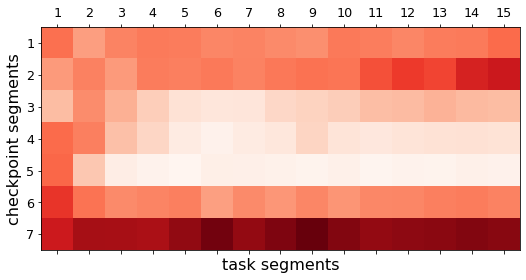

In [150]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=list(map(lambda x: x[1], table.columns)), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=table.index, fontsize=fs*0.8)
plt.show()

# babi-long random V2


In [354]:
!cd ..; python parse_tb.py

  0%|          | 0/58 [00:00<?, ?it/s]
2023-04-12 16:52:16.376018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-12 16:52:16.376056: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
  0%|          | 0/18 [00:00<?, ?it/s]


In [388]:
res_df = pd.read_csv('../results/babilong_random_v2.csv')

In [389]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


In [390]:
res_df.num_steps = res_df.num_steps.fillna(3000)
res_df = res_df[res_df.num_steps > 990]

In [391]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']
# group_df

In [392]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).count()[['best_valid_exact_match']]
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                     \
eval_segment                         1    2    3    4    5    6    7    8      
checkpoint_segment                                                             
1                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
2                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
3                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
4                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
5                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
6                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
7                                     2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   
8                                     2.0  2.0  2.0  1.0  2.0  2.0  2.0  2.0   
9                                     4.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0   

                              ...                                          \
eval_segment       9    10    ... 13   14   15   20   32   64   128  256    
checkpoint_segment            ...                                           
1                   2.0  2.0  ...  2.0  2.0  2.0  NaN  NaN  NaN  NaN  NaN   
2                   2.0  2.0  ...  2.0  2.0  2.0  NaN  NaN  NaN  NaN  NaN   
3                   2.0  2.0  ...  2.0  2.0  2.0  NaN  NaN  NaN  NaN  NaN   
4                   2.0  2.0  ...  2.0  2.0  2.0  NaN  NaN  NaN  NaN  NaN   
5                   2.0  2.0  ...  2.0  2.0  2.0  NaN  NaN  NaN  NaN  NaN   
6                   2.0  2.0  ...  2.0  2.0  2.0  NaN  NaN  NaN  NaN  NaN   
7                   2.0  2.0  ...  2.0  2.0  2.0  1.0  1.0  1.0  1.0  1.0   
8                   2.0  2.0  ...  2.0  2.0  2.0  NaN  NaN  NaN  NaN  NaN   
9                   2.0  2.0  ...  2.0  2.0  2.0  NaN  NaN  NaN  NaN  NaN   

                              
eval_segment       512  1024  
checkpoint_segment            
1                   NaN  NaN  
2                   NaN  NaN  
3                   NaN  NaN  
4                   NaN  NaN  
5                   NaN  NaN  
6                   NaN  NaN  
7                   1.0  1.0  
8                   NaN  NaN  
9                   NaN  NaN  

[9 rows x 22 columns]

In [393]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                      \
eval_segment                         1           2           3           4      
checkpoint_segment                                                              
1                                   100.0   17.497602   15.699904   15.939597   
2                                   100.0  100.000000   99.496643   96.716202   
3                                   100.0  100.000000   99.928093  100.000000   
4                                   100.0   99.952061   99.952061   99.976032   
5                                   100.0  100.000000  100.000000  100.000000   
6                                   100.0  100.000000   99.976032  100.000000   
7                                   100.0  100.000000   99.976032  100.000000   
8                                   100.0  100.000000  100.000000  100.000000   
9                                   100.0  100.000000   99.976032  100.000000   

                                                                             \
eval_segment             5          6          7           8           9      
checkpoint_segment                                                            
1                   14.717162  17.114094  16.490891   16.299137   16.826463   
2                   89.141895  76.749763  65.436241   54.985617   42.689358   
3                   99.928093  99.832218  99.856186   99.424736   99.232983   
4                   99.952065  99.952065  99.928093   99.904121   99.928093   
5                   99.976032  99.976032  99.976032  100.000000  100.000000   
6                   99.976032  99.976032  99.976032   99.880154   99.904125   
7                   99.952061  99.976032  99.976032   99.904121   99.904125   
8                   99.952065  99.976032  99.976032   99.976032   99.976032   
9                   99.976032  99.976032  99.976032   99.976032   99.976032   

                               ...                                    \
eval_segment             10    ...       13          14         15     
checkpoint_segment             ...                                     
1                   17.593481  ...  16.490892   16.227229  16.227229   
2                   35.738256  ...  25.743049   23.897411  22.291467   
3                   97.411312  ...  88.590603   87.775646  85.953979   
4                   99.832214  ...  99.880154   99.928093  99.832214   
5                   99.976032  ...  99.952065  100.000000  99.952065   
6                   99.856186  ...  99.808247   99.712368  99.808247   
7                   99.880154  ...  99.880154   99.784275  99.856186   
8                   99.976032  ...  99.976032   99.976032  99.952061   
9                   99.976032  ...  99.952061   99.928093  99.976032   

                                                                           \
eval_segment             20         32         64         128        256    
checkpoint_segment                                                          
1                         NaN        NaN        NaN        NaN        NaN   
2                         NaN        NaN        NaN        NaN        NaN   
3                         NaN        NaN        NaN        NaN        NaN   
4                         NaN        NaN        NaN        NaN        NaN   
5                         NaN        NaN        NaN        NaN        NaN   
6                         NaN        NaN        NaN        NaN        NaN   
7                   99.904121  99.808243  99.712372  98.849472  98.465965   
8                         NaN        NaN        NaN        NaN        NaN   
9                         NaN        NaN        NaN        NaN        NaN   

                                          
eval_segment             512        1024  
checkpoint_segment                        
1                         NaN        NaN  
2                         NaN        NaN  
3                         NaN        NaN  
4                         NaN        NaN  
5     

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


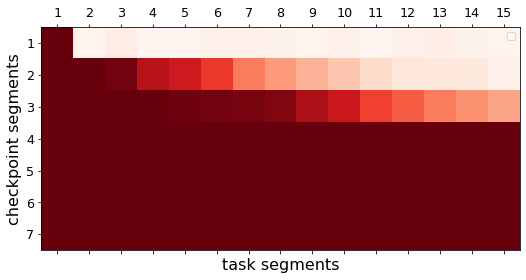

In [435]:
fs = 16
tab = table[table.columns[:15]]
plt.matshow(tab.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(tab.shape[1]), labels=list(map(lambda x: x[1], tab.columns)), fontsize=fs*0.8)
plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.show()

best_valid_exact_match                                      \
eval_segment                           1           2           3           4    
checkpoint_segment                                                              
1                                   100.0   16.347076   18.839886   15.771812   
2                                   100.0  100.000000   97.890701   83.844681   
3                                   100.0  100.000000  100.000000  100.000000   
4                                   100.0  100.000000  100.000000  100.000000   
5                                   100.0  100.000000  100.000000  100.000000   
6                                   100.0  100.000000  100.000000  100.000000   
7                                   100.0  100.000000  100.000000  100.000000   

                                                                    \
eval_segment                5           6           7           8    
checkpoint_segment                                                   
1                    15.052732   16.874401   16.778524   16.395014   
2                    77.852348   68.887825   52.301056   44.630871   
3                    98.657715   97.986580   96.979866   95.206139   
4                   100.000000  100.000000  100.000000  100.000000   
5                    99.952065  100.000000  100.000000  100.000000   
6                    99.952065  100.000000   99.808243  100.000000   
7                   100.000000   99.952065   99.808243   99.952065   

                                                                    \
eval_segment                9           10          11          12   
checkpoint_segment                                                   
1                    16.155321   16.970278   15.675935   16.970278   
2                    38.302971   33.077660   27.181208   22.627037   
3                    87.583893   78.523491   66.538834   60.450623   
4                   100.000000  100.000000  100.000000  100.000000   
5                    99.904121   99.952065   99.904121   99.952065   
6                    99.904121   99.952065   99.952065   99.904121   
7                   100.000000   99.952065  100.000000   99.952065   

                                                        
eval_segment                13          14          15  
checkpoint_segment                                      
1                    18.552254   16.634708   16.251198  
2                    21.524448   21.093000   17.162033  
3                    52.684563   46.644295   42.090126  
4                   100.000000  100.000000  100.000000  
5                    99.952065  100.000000  100.000000  
6                   100.000000  100.000000  100.000000  
7                    99.952065  100.000000  100.000000

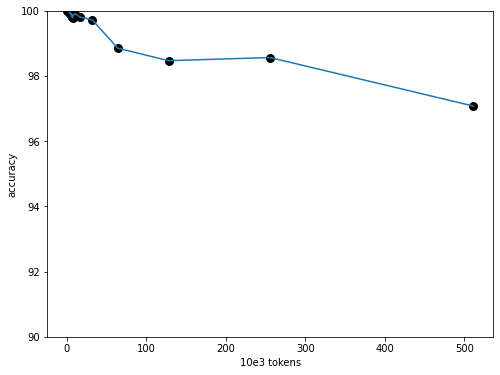

In [395]:
slice = gb.reset_index()[gb.reset_index().checkpoint_segment == 7]

plt.figure(figsize=(8, 6))
# x_values = np.log10(slice.eval_segment * 499)
x_values = slice.eval_segment * 499 / 1000
y_values = slice.best_valid_exact_match
plt.scatter(x_values, y_values, lw=3, color='k')
plt.plot(x_values, y_values)
plt.ylim(90, 100)
plt.xlabel('10e3 tokens')
plt.ylabel('accuracy')
plt.show()

# babi-long random


In [387]:
!cd ..; python parse_tb.py

  0%|          | 0/58 [00:00<?, ?it/s]
2023-04-13 18:16:24.166205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 18:16:24.166239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
  0%|          | 0/20 [00:00<?, ?it/s]


In [420]:
res_df = pd.read_csv('../results/babilong_random.csv')

In [421]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


In [422]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]

In [423]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']

In [424]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                      \
eval_segment                         1           2           3           4      
checkpoint_segment                                                              
1                                   100.0   16.347076   18.839886   15.771812   
2                                   100.0  100.000000   97.890701   83.844681   
3                                   100.0  100.000000  100.000000  100.000000   
4                                   100.0  100.000000  100.000000  100.000000   
5                                   100.0  100.000000  100.000000  100.000000   
6                                   100.0  100.000000  100.000000  100.000000   
7                                   100.0  100.000000  100.000000  100.000000   

                                                                    \
eval_segment              5           6           7           8      
checkpoint_segment                                                   
1                    15.052732   16.874401   16.778524   16.395014   
2                    77.852348   68.887825   52.301056   44.630871   
3                    98.657715   97.986580   96.979866   95.206139   
4                   100.000000  100.000000  100.000000  100.000000   
5                    99.952065  100.000000  100.000000  100.000000   
6                    99.952065  100.000000   99.808243  100.000000   
7                   100.000000   99.952065   99.808243   99.952065   

                                            ...                          \
eval_segment              9           10    ...        12          13     
checkpoint_segment                          ...                           
1                    16.155321   16.970278  ...   16.970278   18.552254   
2                    38.302971   33.077660  ...   22.627037   21.524448   
3                    87.583893   78.523491  ...   60.450623   52.684563   
4                   100.000000  100.000000  ...  100.000000  100.000000   
5                    99.904121   99.952065  ...   99.952065   99.952065   
6                    99.904121   99.952065  ...   99.904121  100.000000   
7                   100.000000   99.952065  ...   99.952065   99.952065   

                                                                             \
eval_segment              14          15         32         64         128    
checkpoint_segment                                                            
1                    16.634708   16.251198        NaN        NaN        NaN   
2                    21.093000   17.162033        NaN        NaN        NaN   
3                    46.644295   42.090126        NaN        NaN        NaN   
4                   100.000000  100.000000        NaN        NaN        NaN   
5                   100.000000  100.000000        NaN        NaN        NaN   
6                   100.000000  100.000000        NaN        NaN        NaN   
7                   100.000000  100.000000  99.952065  99.856186  99.472672   

                                                     
eval_segment             256        512        1024  
checkpoint_segment                                   
1                         NaN        NaN        NaN  
2                         NaN        NaN        NaN  
3                         NaN        NaN        NaN  
4                         NaN        NaN        NaN  
5                         NaN        NaN        NaN  
6                         NaN        NaN        NaN  
7                   98.849472  97.603065  97.746887  

[7 rows x 21 columns]

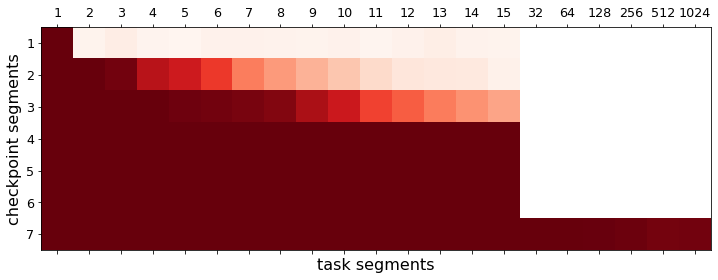

In [425]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=list(map(lambda x: x[1], table.columns)), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=table.index, fontsize=fs*0.8)
plt.show()

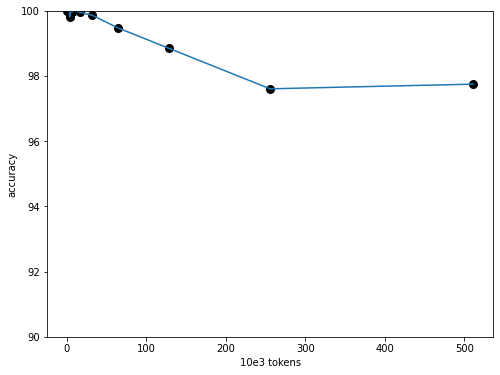

In [426]:
slice = gb.reset_index()[gb.reset_index().checkpoint_segment == 7]

plt.figure(figsize=(8, 6))
# x_values = np.log10(slice.eval_segment * 499)
x_values = slice.eval_segment * 499 / 1000
y_values = slice.best_valid_exact_match
plt.scatter(x_values, y_values, lw=3, color='k')
plt.plot(x_values, y_values)
plt.ylim(90, 100)
plt.xlabel('10e3 tokens')
plt.ylabel('accuracy')
plt.show()

# babi-long 

In [411]:
!cd ..; python parse_tb.py

  0%|          | 0/333 [00:00<?, ?it/s]
2023-04-13 18:38:22.584421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 18:38:22.584454: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
  0%|          | 0/20 [00:00<?, ?it/s]


In [412]:
res_df = pd.read_csv('../results/babilong.csv')

In [413]:
res_df['memory_layers'] = res_df.memory_layers.fillna('')
res_df['horizontal_memory'] = res_df.model_cls.apply(lambda x: 'HorizontalMemory' in x)
res_df['tag'] = res_df.model_path.apply(lambda x: x.split('_regular')[1].split('/run')[0])


### various task size

In [415]:
# slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_seq_len > 512)]
slc = res_df[(res_df.input_size >= 499) & (res_df.model_path.apply(lambda x: 'task' in x))]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']

In [416]:
eval_df = slc[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
# gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]

/tmp/ipykernel_448167/3498173823.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eval_df = slc[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()


In [417]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                      \
eval_segment                         1           2           3           4      
checkpoint_segment                                                              
1                              100.000000   16.634707   15.100671   16.251198   
2                              100.000000  100.000000   99.568554   90.604027   
3                               99.952061  100.000000  100.000000  100.000000   
4                               99.928093  100.000000  100.000000  100.000000   
5                               99.616489  100.000000  100.000000  100.000000   
6                              100.000000  100.000000  100.000000  100.000000   
7                              100.000000  100.000000  100.000000  100.000000   

                                                                    \
eval_segment              5           6           7           8      
checkpoint_segment                                                   
1                    16.634707   16.922340   17.138063   16.035474   
2                    76.078617   67.857143   48.513903   39.765100   
3                   100.000000   97.579098   95.541706   93.839886   
4                   100.000000   97.722916   95.493767   93.839886   
5                   100.000000   97.579098   95.565674   93.911793   
6                   100.000000  100.000000  100.000000  100.000000   
7                   100.000000  100.000000  100.000000  100.000000   

                                            ...                        \
eval_segment              9           10    ...       18         19     
checkpoint_segment                          ...                         
1                    16.490892   17.593480  ...  16.347076  15.819751   
2                    33.077660   27.612656  ...  17.042186  16.514861   
3                    91.706615   86.697029  ...  53.163952  49.784277   
4                    91.442955   86.433369  ...  52.085329  48.705658   
5                    91.059444   86.457336  ...  51.030682  49.065197   
6                   100.000000  100.000000  ...  99.976032  99.928093   
7                   100.000000  100.000000  ...  99.976032  99.976032   

                                                                           \
eval_segment             20         32         64         128        256    
checkpoint_segment                                                          
1                   17.066155        NaN        NaN        NaN        NaN   
2                   16.371045        NaN        NaN        NaN        NaN   
3                   46.716204        NaN        NaN        NaN        NaN   
4                   46.236816        NaN        NaN        NaN        NaN   
5                   47.291468        NaN        NaN        NaN        NaN   
6                   99.880154        NaN        NaN        NaN        NaN   
7                   99.952065  99.232979  98.226273  96.500481  95.206139   

                                                    
eval_segment             512        1024      2048  
checkpoint_segment                                  
1                         NaN        NaN       NaN  
2                         NaN        NaN       NaN  
3                         NaN        NaN       NaN  
4                         NaN        NaN       NaN  
5                         NaN        NaN       NaN  
6                         NaN        NaN       NaN  
7                   93.192711  92.689358  90.41227  

[7 rows x 27 columns]

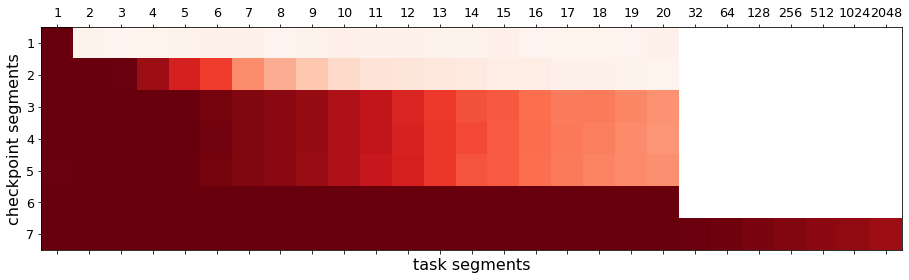

In [418]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=list(map(lambda x: x[1], table.columns)), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=table.index, fontsize=fs*0.8)
plt.show()

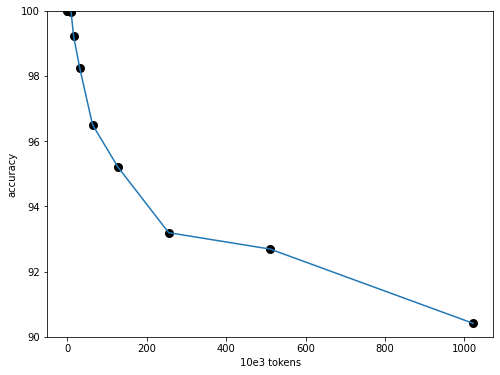

In [419]:
slice = gb.reset_index()[gb.reset_index().checkpoint_segment == 7]

plt.figure(figsize=(8, 6))
# x_values = np.log10(slice.eval_segment * 499)
x_values = slice.eval_segment * 499 / 1000
y_values = slice.best_valid_exact_match
plt.scatter(x_values, y_values, lw=3, color='k')
plt.plot(x_values, y_values)
plt.ylim(90, 100)
plt.xlabel('10e3 tokens')
plt.ylabel('accuracy')
plt.show()

### fixed task length


In [755]:
# slc = res_df_full[(res_df_full.input_seq_len < 513) | (res_df_full.max_n_segments == 1)]

# slc = slc[~((slc.input_size == 512) & (slc.max_n_segments > 1))]
# slc = slc[slc.num_mem_tokens != 1]
slc = res_df[(res_df.max_n_segments == 1) | (res_df.input_size < 512)]

gb_cols = ['from_pretrained', 'max_n_segments', 'num_mem_tokens', 'memory_layers', 'horizontal_memory', 'input_size', 'tag']
metric = 'best_valid_exact_match'
group_df = slc.groupby(gb_cols).mean()[[metric]]
group_df['std'] = slc.groupby(gb_cols).std()[[metric]]
group_df['n_runs'] = slc.groupby(gb_cols).count()[metric]
group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
group_df['tags'] = slc.groupby(gb_cols).agg({'tag':tuple})['tag']
# group_df

In [756]:
group_df['solved_pct'] = group_df.runs.apply(lambda x: (np.array(x) > 99).mean())

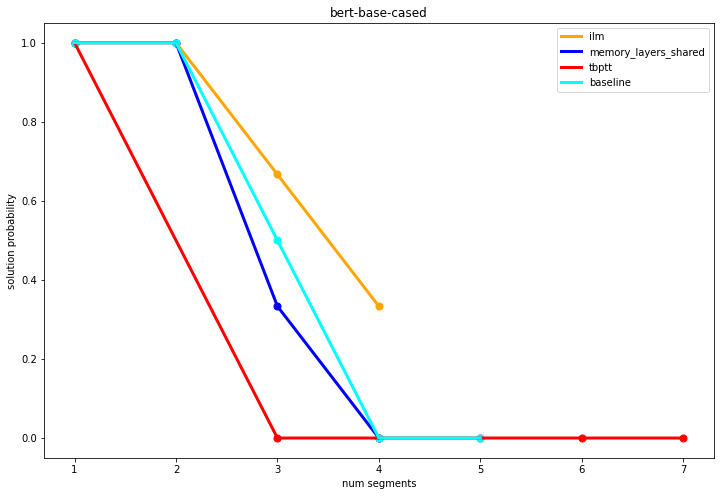

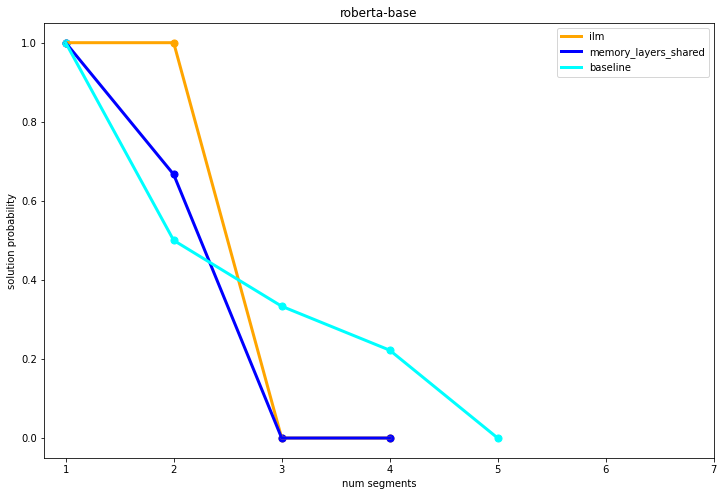

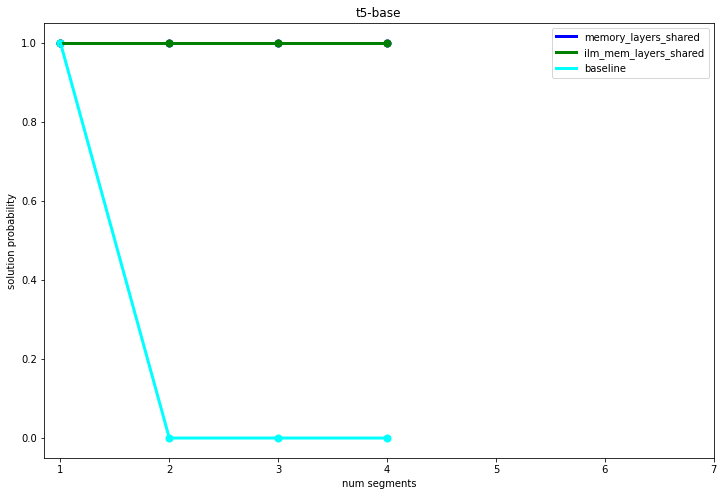

In [757]:
tags = ['_ilm', '_memory_layers_shared', '_ilm_mem_layers_shared', '_tbptt', '']


slc = res_df.copy()
slc.loc[slc.tag.apply(lambda x: 'tbptt' in x), 'tag'] = '_tbptt'
slc = slc[slc.max_n_segments <= 7]
for from_pretrained in np.unique(res_df.from_pretrained):

    plt.figure(figsize=(12,8))
    plt.title(from_pretrained)

    colors = ['orange', 'blue', 'green', 'red', 'cyan', 'brown', 'magenta', 'pink']
    for i, tag in enumerate(tags):
        num_mem = 10
        if tag in {'_baseline'}:
            num_mem = 0

        slice = slc[(slc.from_pretrained == from_pretrained) & (slc.num_mem_tokens == num_mem) & (slc.tag == tag)]
        if slice.shape[0] == 0:
            continue
        gb_cols = ['from_pretrained', 'max_n_segments','num_mem_tokens', 'lr', 'tag']
        metric = 'best_valid_exact_match'
        group_df = slice.groupby(gb_cols).mean()[[metric]]
        # group_df['std'] = slice.groupby(gb_cols).std()[[metric]]
        # group_df['max'] = slice.groupby(gb_cols).max()[[metric]]
        # group_df['min'] = slice.groupby(gb_cols).min()[[metric]]
        group_df['runs'] = slc.groupby(gb_cols).agg({metric:tuple})[metric].apply(lambda x: [round(i,2) for i in x])
        group_df['solved_pct'] = group_df.runs.apply(lambda x: (np.array(x) > 99).mean())        
        group_df = group_df.reset_index()

        max_n_segments = list(group_df.max_n_segments.values)
        metric_values = list(group_df['solved_pct'].values)
        # stds = list(group_df['std'].values)
        # mins = list(group_df['min'].values)
        # maxs = list(group_df['max'].values)
        # if 1 not in max_n_segments and num_mem != 0:
        #     max_n_segments = [1] + max_n_segments
        #     value = res_df[(res_df.from_pretrained == from_pretrained) & (res_df.num_mem_tokens == num_mem) & (res_df.tag == '_vanilla') & (res_df.max_n_segments == 1)][metric].mean()
        max_n_segments = [1] + max_n_segments
        metric_values = [1] + metric_values
            # mins = [value] + mins
            # maxs = [value] + maxs
        if tag == '':
            tag = '_baseline'

        plt.scatter(max_n_segments, metric_values, s=50, color=colors[i])
        plt.plot(max_n_segments, metric_values, lw=3, label=tag[1:], color=colors[i])
        # plt.errorbar(max_n_segments, metric_values, stds, lw=4, markeredgecolor='k', markersize=16, capsize=10, elinewidth=2)
        # plt.fill_between(max_n_segments, mins, maxs, color=colors[i], alpha=0.3)


    # plt.legend(plots, tags)
    plt.xlabel('num segments')
    plt.xticks(range(1, 8))
    plt.ylabel('solution probability')
    plt.legend()
    plt.show()

#### curriculum eval

regular

In [386]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & (~res_df.sum_loss)].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
# eval_df = eval_df[~((eval_df.checkpoint_segment == 2) & (eval_df.best_valid_exact_match < 20) & (eval_df.eval_segment < 10))]
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).mean()[['best_valid_exact_match']]


In [387]:
# import math
# print(' '.join([str(math.ceil(500 / i + 13)) for i in range(1, 26)]))
# print(' '.join([str(i) for i in range(1, 26)]))

In [388]:
# eval_df[eval_df['eval_segment'] == 15]

In [385]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                             ...     \
eval_segment                           1  2  3  4  5  6  7  8  9  10  ... 16   
checkpoint_segment                                                    ...      
1                                       6  2  2  2  2  2  2  1  1  1  ...  1   
2                                       6  2  2  2  2  2  2  1  1  1  ...  1   
3                                       5  3  3  3  3  3  3  2  2  2  ...  2   
4                                       5  3  3  3  3  3  3  2  2  2  ...  2   
5                                       5  3  3  3  3  3  3  2  2  2  ...  2   
6                                       5  3  3  3  3  3  3  2  2  2  ...  2   
7                                       5  3  3  3  3  3  2  2  2  2  ...  2   
8                                       5  3  3  3  3  3  2  2  2  2  ...  2   

                                               
eval_segment       17 18 19 20 21 22 23 24 25  
checkpoint_segment                             
1                   1  2  1  1  2  3  1  1  1  
2                   1  2  1  1  2  3  1  1  1  
3                   2  2  2  3  4  4  2  2  2  
4                   2  2  2  3  3  4  2  2  2  
5                   2  2  2  3  2  3  2  2  2  
6                   2  2  2  3  2  3  2  2  2  
7                   2  2  2  3  2  2  2  2  2  
8                   2  2  2  3  2  2  2  2  2  

[8 rows x 25 columns]

In [389]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                      \
eval_segment                           1           2           3           4    
checkpoint_segment                                                              
1                              100.000000   16.738506   15.972222   16.091954   
2                               59.027778  100.000000   90.086208   81.896553   
3                               66.886973  100.000000   99.936145   99.808428   
4                               67.030653  100.000000  100.000000  100.000000   
5                               67.107280  100.000000  100.000000  100.000000   
6                               67.270115  100.000000  100.000000  100.000000   
7                               67.126436  100.000000  100.000000  100.000000   
8                               67.183909  100.000000  100.000000  100.000000   

                                                                               \
eval_segment                5           6           7           8          9    
checkpoint_segment                                                              
1                    16.858237   16.379311   17.073755   16.235632  15.565134   
2                    66.738504   54.765324   48.108238   29.741379  23.850574   
3                    93.215197   82.120051   66.730525   52.897509  47.078545   
4                    99.744573   98.930397   93.805875   77.131227  72.749041   
5                    99.984037   99.952108   99.824394   99.233719  97.030651   
6                   100.000000  100.000000  100.000000  100.000000  99.760536   
7                   100.000000  100.000000  100.000000  100.000000  99.808430   
8                   100.000000  100.000000  100.000000  100.000000  99.808430   

                               ...                                   \
eval_segment               10  ...         16         17         18   
checkpoint_segment             ...                                    
1                   16.379311  ...  17.049809  16.283525  16.379311   
2                   27.059387  ...  18.821838  18.438698  18.438698   
3                   41.139847  ...  29.358237  27.514368  27.394636   
4                   67.672415  ...  41.738505  38.553640  37.547893   
5                   94.612072  ...  66.355364  58.165710  58.405172   
6                   99.066093  ...  87.308430  86.182949  84.339081   
7                   99.066093  ...  87.595787  84.530651  85.057472   
8                   99.305557  ...  87.835251  85.727970  85.129311   

                                                                           \
eval_segment               19         20         21         22         23   
checkpoint_segment                                                          
1                   17.337164  16.379311  15.900383  16.251596  16.858238   
2                   16.379311  18.295019  18.199234  15.964240  17.097702   
3                   23.491380  26.181354  23.395594  22.617337  21.360153   
4                   32.207854  35.265006  30.220306  26.556513  27.514367   
5                   55.124521  46.120689  51.843868  52.474458  47.725096   
6                   81.704983  87.468071  80.531609  71.807153  76.963604   
7                   82.351532  87.755427  80.771072  77.035440  76.460728   
8                   81.800766  87.484037  80.292145  77.179117  75.838121   

                                          
eval_segment               24         25  
checkpoint_segment                        
1                   15.900383  17.528736  
2                   18.247126  15.996168  
3                   20.617817  22.820881  
4                   28.448276  28.113027  
5                   43.773947  46.839081  
6                   69.492336  71.719347  
7                   70.354404  74.832376  
8                   70.713604  71.479883  

[8 rows x 25 columns]

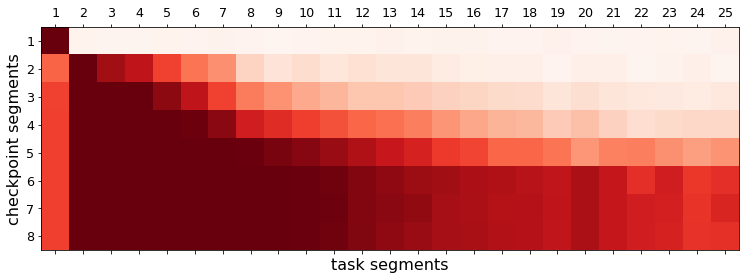

In [390]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=range(1, table.shape[1]+1), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=range(1, table.shape[0]+1), fontsize=fs*0.8)
plt.show()

sum loss

In [391]:
eval_df = res_df[(res_df.tag.apply(lambda x: 'eval' in x and 'tbptt' not in x)) & ((res_df.sum_loss) | (res_df.tag.apply(lambda x: 'sum_loss' in x)) | res_df.tag.apply(lambda x: x[:3] == '_1-'))].copy()
eval_df['checkpoint_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[0][1:]))
eval_df['eval_segment'] = eval_df.tag.apply(lambda x: int(x.split('-')[1].split('seg')[0]))
gb = eval_df.groupby(['checkpoint_segment', 'eval_segment']).count()[['best_valid_exact_match']]

In [392]:
table = pd.pivot_table(gb, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_exact_match'])
table

best_valid_exact_match                                     \
eval_segment                           1    2    3    4    5    6    7    8    
checkpoint_segment                                                             
1                                     6.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
2                                     3.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN   
3                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
4                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
5                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
6                                     3.0  2.0  2.0  2.0  2.0  2.0  2.0  1.0   
7                                     3.0  2.0  2.0  2.0  2.0  2.0  1.0  1.0   
8                                     3.0  2.0  2.0  2.0  2.0  2.0  1.0  1.0   

                              ...                                          \
eval_segment         9    10  ...   16   17   18   19   20   21   22   23   
checkpoint_segment            ...                                           
1                   1.0  1.0  ...  1.0  1.0  2.0  1.0  1.0  2.0  3.0  1.0   
2                   NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0   
4                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   
5                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   
6                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   
7                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   
8                   1.0  1.0  ...  1.0  1.0  1.0  1.0  2.0  1.0  1.0  1.0   

                              
eval_segment         24   25  
checkpoint_segment            
1                   1.0  1.0  
2                   NaN  NaN  
3                   1.0  1.0  
4                   1.0  1.0  
5                   1.0  1.0  
6                   1.0  1.0  
7                   1.0  1.0  
8                   1.0  1.0  

[8 rows x 25 columns]

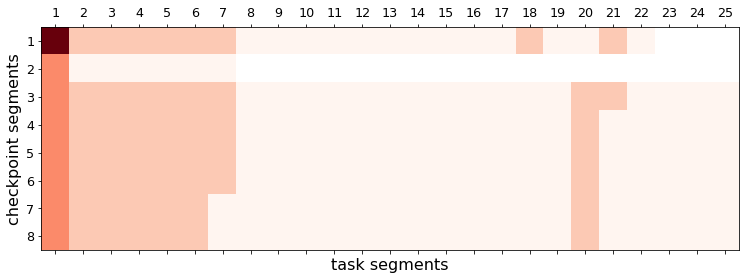

In [371]:
fs = 16
plt.matshow(table.values, cmap='Reds')
plt.xlabel('task segments', fontsize=fs)
plt.ylabel('checkpoint segments', fontsize=fs)
plt.xticks(range(table.shape[1]), labels=list(map(lambda x: x[1], table.columns)), fontsize=fs*0.8)
plt.yticks(range(table.shape[0]), labels=table.index, fontsize=fs*0.8)
plt.show()

### wikitext


In [96]:
!cd ..;python parse_tb.py

  0%|          | 0/41 [00:00<?, ?it/s]
2023-04-06 12:34:16.453394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 12:34:16.453468: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [88]:
df = pd.read_csv('../results/wikitext.csv')

In [93]:
df.num_mem_tokens = df.num_mem_tokens.fillna('NA')
df.share_memory_layers = df.share_memory_layers.fillna(False)
df.k2 = df.k2.fillna(1)
df['from_cpt'] = (~df.backbone_cpt.isna()).fillna(False)
df.freeze_model_weights = df.freeze_model_weights.fillna(False)

In [94]:
df = df[df.best_valid_loss < 3]

In [95]:
gb_cols = ['from_pretrained', 'model_cls', 'num_mem_tokens', 'lr', 'lr_scheduler', 'k2', 'freeze_model_weights', 'from_cpt']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
from_pretrained model_cls                                          num_mem_tokens lr       lr_scheduler         k2   freeze_model_weights from_cpt                    
gpt2            modeling_rmt.language_modeling:RMTDecoderLMHead    10.0           0.000005 linear                1.0 False                False            2.696082   
                                                                   25.0           0.000005 constant_with_warmup  1.0 False                False            2.693921   
                                                                                                                 2.0 False                False            2.693101   
                                                                                           linear                1.0 False                False            2.700119   
                                                                                                                 2.0 False                False            2.697857   
                modeling_rmt.language_modeling:RMTDecoderMemory... 10.0           0.000001 linear                1.0 False                False            2.857818   
                                                                                                                 2.0 False                False            2.839722   
                                                                                  0.000005 linear                1.0 False                False            2.724896   
                                                                                                                 2.0 False                False            2.709527   
                                                                                  0.000010 constant_with_warmup  1.0 True                 True             2.764399   
                                                                                           linear                1.0 False                False            2.698679   
                                                                                                                                          True             2.695399   
                                                                                                                 2.0 False                False            2.684810   
                                                                                  0.000100 constant_with_warmup  1.0 True                 True             2.783597   
                modeling_rmt:RMTDecoderForCausalLM                 10.0           0.000005 constant_with_warmup  1.0 False                False            2.692568   
                                                                                                                 2.0 False                False            2.688242   
                                                                                                                 3.0 False                False            2.688129   
                                                                                  0.000010 constant_with_warmup  1.0 False                False            2.696101   
                                                                                           linear                1.0 False                False            2.707594   
                                                                                  0.000050 constant_with_warmup  1.0 False                False            2.706325   
                                                                                  0.000100 constant_with_warmup  1.0 False                False            2.719023   
                                                                   25.0           0.000010 linear                1.0 False                False            2.833547   
                                                                   50.0           0.000005 constant_with_warmup  1.0 False                Fa

### qmsum

In [348]:
!cd ..;python parse_tb.py

  0%|          | 0/1913 [00:00<?, ?it/s]


In [19]:
# res_df = pd.read_csv('../results/qmsum.csv')

In [ ]:
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)

In [ ]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering']
metric_cols = ['best_valid_rouge/geometric_mean']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = res_df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

In [37]:
# group_df.sort_values('best_valid_rouge/geometric_mean')

### quality

In [603]:
!cd ..;python parse_tb.py

  0%|          | 0/1630 [00:00<?, ?it/s]


In [45]:
# res_df = pd.read_csv('../results/quality.csv')
paths = [
        '../results/quality.csv',
        '../results/quality_new.csv'
        ]
         

In [46]:
res_df = pd.concat([pd.read_csv(p) for p in paths])
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
# res_df.padding_side = res_df.padding_side.fillna('left')
# res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)
res_df = res_df[res_df.num_steps.isin({'UNKNOWN', 3200, 1600})]

In [47]:
# res_df = res_df[res_df.best_valid_exact_match > 1]

In [48]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering' ]
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering                           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        31.208099   
                               984           25.0           0.00020 linear       True     bidirectional                  21.524450   
                                                                                          regular                         0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN                        28.395667   
                                                            0.00010 linear       UNKNOWN  UNKNOWN                        30.021550   
                               1002          10.0           0.00020 linear       False    regular                         0.023950   
                                                                                          repeat_first                   28.799150   
                                                                                 True     bidirectional                  28.811151   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        32.454498   
                               1503          10.0           0.00020 linear       True     bidirectional                  24.017300   
                                                                                          regular                         0.000000   
                                                                                          repeat_first                   27.468800   

                                                                                                                 std  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering             
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               984           25.0           0.00020 linear       True     bidirectional     1.559242   
                                                                                          regular           0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN           0.508137   
                                                            0.00010 linear       UNKNOWN  UNKNOWN           0.167795   
                               1002          10.0           0.00020 linear       False    regular           0.026236   
                                                                                          repeat_first      0.638873   
                                                                                 True     bidirectional     0.813526   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               1503          10.0           0.00020 linear       True     bidirectional          NaN   
                                                                                          regular           0.000000   
                                                                                          repeat_first           NaN   

                                                                                                            n_runs  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                1   
                               984           25.0           0.00020 linear       True     bidirectional          2   
                                                                              